Requires py3 and new saga

# Imports/Setup 

In [160]:
import os
import sys
import urllib
from collections import defaultdict

import numpy as np

from astropy import units as u
from astropy import table
from astropy.coordinates import SkyCoord, EarthLocation, get_sun
from astropy.time import Time

import astroplan, astroplan.plots

import tqdm

from importlib import reload

In [2]:
%matplotlib inline
from matplotlib import style, pyplot as plt

The below cells build the saga repo and sets the path to look for it

In [3]:
working_dir = os.path.abspath('..')

In [4]:
%cd ../../saga
sagadir = !pwd
sagadir = sagadir[0]
!python setup.py build
%cd $working_dir

/Users/erik/projects/saga/saga
running build
running build_py
/Users/erik/projects/saga/erik


In [5]:
sagalibdir = os.path.join(sagadir, 'build/lib')
print('Adding', sagalibdir, 'to the python path')
sys.path.insert(0, sagalibdir)

import SAGA as saga

Adding /Users/erik/projects/saga/saga/build/lib to the python path


In [6]:
import decals

In [7]:
aat = astroplan.Observer.at_site('Anglo-Australian Observatory')

run_start = aat.midnight(Time('2018-6-10'), 'next')
run_end = aat.midnight(Time('2018-6-15'), 'next')
run_mid = aat.midnight(Time((run_start.jd + run_end.jd)/2, format='jd'))

### First we load the extended host list (Flag0-not-just-sdss)

In [8]:
db = saga.Database(os.path.join(os.environ['HOME'],'Dropbox/SAGA/'))
hostcats = saga.HostCatalog(db)

notsdsshosts = hostcats.load('no_sdss_flags')
notsdsshosts

NSAID,RA,Dec,PGC#,vhelio,distance,r,i,z,I,K,K_err,flag,K_abs,r_abs,b,dist_to_group,brightest_K_nearby,SDSS_FRACGOOD,RA_sub,Dec_sub,othername,vhelio_sub,vhelio_err,distance_sub,dist_2MASS_NSA,u,u_err,A_u,M_u,g,g_err,A_g,M_g,r_sub,r_err,A_r,M_r,i_sub,i_err,A_i,M_i,z_sub,z_err,A_z,M_z,J,J_err,A_J,M_J,H,H_err,A_H,M_H,K_sub,K_err_sub,A_K,M_K,stellar_mass,sersic_n,MK_compiled,SAGA_name,coord
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,"deg,deg"
int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,str16,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str11,object
-1,133.911,78.2235,25069,1403.0,20.3137,--,--,--,--,6.94,0.016,48,-24.5989,--,32.689,7.86852,8.586,0.0,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,-24.5989,,"133.911,78.2235"
145729,224.594,-1.09102,53499,1922.0,28.4038,11.9155,11.457,11.0653,9.49,7.693,0.019,0,-24.5739,-20.3514,48.4266,3.55266,12.164,0.983605,224.594,-1.09102,g1458227-010528,1922.0,-1,28.4038,0.520533,14.1855,0.0109577,0.245277,-18.3542,12.3155,0.000563506,0.191118,-20.1622,11.2899,0.000420059,0.132215,-21.1207,10.7733,0.000416391,0.0982496,-21.6016,10.3333,0.000670495,0.0730797,-22.0151,8.594,0.02,0.0410241,-23.7147,7.951,0.023,0.02598,-24.3439,7.713,0.031,0.0174743,-24.5597,19800000000.0,2.82806,-24.5739,Othello,"224.594,-1.09102"
132278,38.8656,-9.3562,9843,1510.0,20.493,11.7035,11.2789,11.4256,7.03,6.99,0.006,32,-24.568,-19.8545,-59.6963,8.12763,--,0.506566,38.8656,-9.3562,g0235277-092122,1510.0,-1,20.493,0.71954,12.3913,0.00746019,0.114519,-19.3035,11.3647,0.00256455,0.0892326,-20.2996,10.9815,0.00237625,0.0617307,-20.6502,10.5209,0.00161676,0.0458725,-21.0923,10.639,0.072169,0.0341207,-20.9616,7.336,0.001,0.0191541,-24.2426,7.351,0.002,0.01213,-24.2213,7.0,0.003,0.00815872,-24.5574,6800000000.0,0.557528,-24.568,,"38.8656,-9.3562"
-1,47.4393,-20.5792,11819,1682.0,24.371,--,--,--,9.25,7.372,0.023,48,-24.5624,--,-57.8093,4.98312,12.041,0.0,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,-24.5624,,"47.4393,-20.5792"
-1,312.177,-37.9973,65436,2652.0,38.5222,--,--,--,--,8.384,0.018,48,-24.5446,--,-38.6186,18.8771,12.403,0.0,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,-24.5446,,"312.177,-37.9973"
-1,38.3929,-39.045,9747,2004.0,29.0608,--,--,--,9.84,7.772,0.018,48,-24.5445,--,-65.6357,11.1456,--,0.0,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,-24.5445,,"38.3929,-39.045"
-1,189.354,74.1919,42139,1980.0,28.7109,--,--,--,--,7.748,0.017,48,-24.5422,--,42.901,5.40396,8.843,0.0,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,-24.5422,,"189.354,74.1919"
-1,344.306,-43.3961,70094,1713.0,24.8221,--,--,--,--,7.45,0.018,48,-24.5242,--,-61.8008,5.2904,8.585,0.0,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,-24.5242,,"344.306,-43.3961"


/Users/erik/miniconda3/envs/saga3/lib/python3.6/site-packages/matplotlib/projections/geo.py:353: RuntimeWarning: invalid value encountered in sqrt
  z = np.sqrt(1 - (x / 4) ** 2 - (y / 2) ** 2)


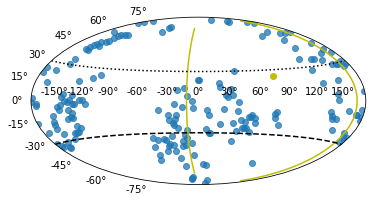

In [9]:
ax = plt.subplot(projection='hammer')

coo = notsdsshosts['coord']
plt.scatter(coo.ra.wrap_at(180*u.deg).rad, coo.dec.rad, alpha=.75)
sun = get_sun(run_start)
plt.scatter([sun.ra.rad], [sun.dec.wrap_at(180*u.deg).rad], c='y')
plt.axvline((sun.ra-90*u.deg).wrap_at(180*u.deg).rad, c='y')
plt.axvline((sun.ra+90*u.deg).wrap_at(180*u.deg).rad, c='y')

plt.axhline(aat.location.lat.radian, c='k', ls='--')
plt.axhline((aat.location.lat + 60*u.deg).radian, c='k', ls=':') # airmass of 2

In [200]:
constraints = [astroplan.AtNightConstraint(), astroplan.AirmassConstraint(2.5)]

host_targets = []
for h in notsdsshosts:
    name = 'NSA{}'.format(h['NSAID'])
    if h['SAGA_name'] != '':
        name = h['SAGA_name']
    elif h['NSAID']==-1:
        name = 'PGC{}'.format(h['PGC#'])
    host_targets.append(astroplan.FixedTarget(h['coord'], name))
    

allobstab = astroplan.observability_table(constraints, aat, host_targets, 
                                          time_range = (run_mid-12*u.hour, run_mid+12*u.hour))
allobstab['tobs'] = allobstab['fraction of time observable']*24*u.hour

obsmsk = 3*u.hour<allobstab['tobs']
obstab = allobstab[obsmsk]
obshosts = notsdsshosts[obsmsk]

obshosts['tobs'] = obstab['tobs']
obshosts['targetobjs'] = np.array(host_targets ,dtype=object)[obsmsk]
obshosts

NSAID,RA,Dec,PGC#,vhelio,distance,r,i,z,I,K,K_err,flag,K_abs,r_abs,b,dist_to_group,brightest_K_nearby,SDSS_FRACGOOD,RA_sub,Dec_sub,othername,vhelio_sub,vhelio_err,distance_sub,dist_2MASS_NSA,u,u_err,A_u,M_u,g,g_err,A_g,M_g,r_sub,r_err,A_r,M_r,i_sub,i_err,A_i,M_i,z_sub,z_err,A_z,M_z,J,J_err,A_J,M_J,H,H_err,A_H,M_H,K_sub,K_err_sub,A_K,M_K,stellar_mass,sersic_n,MK_compiled,SAGA_name,coord,tobs,targetobjs
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,"deg,deg",h,
int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,str16,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str11,object,float64,object
145729,224.594,-1.09102,53499,1922.0,28.4038,11.9155,11.457,11.0653,9.49,7.693,0.019,0,-24.5739,-20.3514,48.4266,3.55266,12.164,0.983605,224.594,-1.09102,g1458227-010528,1922.0,-1,28.4038,0.520533,14.1855,0.0109577,0.245277,-18.3542,12.3155,0.000563506,0.191118,-20.1622,11.2899,0.000420059,0.132215,-21.1207,10.7733,0.000416391,0.0982496,-21.6016,10.3333,0.000670495,0.0730797,-22.0151,8.594,0.02,0.0410241,-23.7147,7.951,0.023,0.02598,-24.3439,7.713,0.031,0.0174743,-24.5597,19800000000.0,2.82806,-24.5739,Othello,"224.594,-1.09102",8.5,"<FixedTarget ""Othello"" at SkyCoord (ICRS): (ra, dec) in deg (224.594, -1.09102)>"
-1,312.177,-37.9973,65436,2652.0,38.5222,--,--,--,--,8.384,0.018,48,-24.5446,--,-38.6186,18.8771,12.403,0.0,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,-24.5446,,"312.177,-37.9973",9.5,"<FixedTarget ""PGC65436"" at SkyCoord (ICRS): (ra, dec) in deg (312.177, -37.9973)>"
-1,38.3929,-39.045,9747,2004.0,29.0608,--,--,--,9.84,7.772,0.018,48,-24.5445,--,-65.6357,11.1456,--,0.0,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,-24.5445,,"38.3929,-39.045",3.5,"<FixedTarget ""PGC9747"" at SkyCoord (ICRS): (ra, dec) in deg (38.3929, -39.045)>"
-1,344.306,-43.3961,70094,1713.0,24.8221,--,--,--,--,7.45,0.018,48,-24.5242,--,-61.8008,5.2904,8.585,0.0,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,-24.5242,,"344.306,-43.3961",7.5,"<FixedTarget ""PGC70094"" at SkyCoord (ICRS): (ra, dec) in deg (344.306, -43.3961)>"
150887,348.683,4.53406,70795,2689.0,37.019,11.9764,11.6247,11.3038,10.57,8.327,0.013,0,-24.5151,-20.8657,-50.6545,5.73166,10.189,0.98742,348.683,4.53406,NGC_7541,2689.0,-1,37.019,0.844612,13.5013,0.00257254,0.285874,-19.6741,12.1673,0.000503632,0.222751,-20.9126,11.3808,0.000382114,0.154098,-21.6316,10.9634,0.000777402,0.114511,-22.004,10.589,0.0018768,0.0851754,-22.3494,9.439,0.005,0.0478142,-23.451,8.757,0.006,0.0302801,-24.1194,8.351,0.007,0.0203666,-24.4949,25100000000.0,0.777359,-24.5151,Catch22,"348.683,4.53406",5.5,"<FixedTarget ""Catch22"" at SkyCoord (ICRS): (ra, dec) in deg (348.683, 4.53406)>"
140594,180.098,-1.10008,37845,1465.0,23.2487,11.1116,10.7406,10.4707,9.35,7.321,0.015,0,-24.511,-20.7204,59.2146,2.29212,12.669,0.985217,180.098,-1.10008,g1200236-010600,1465.0,-1,23.2487,0.508479,12.5696,0.00122745,0.112339,-19.3871,11.1341,0.00028931,0.0875336,-20.795,10.3932,0.000242571,0.0605553,-21.5041,9.98552,0.000254046,0.0449991,-21.896,9.68725,0.000379465,0.0334711,-22.1818,8.271,0.009,0.0187894,-23.5789,7.604,0.012,0.0118991,-24.24,7.33,0.015,0.00800337,-24.5004,20600000000.0,1.7545,-24.511,Alice,"180.098,-1.10008",6.0,"<FixedTarget ""Alice"" at SkyCoord (ICRS): (ra, dec) in deg (180.098, -1.10008)>"
-1,172.883,-30.3077,35539,1733.0,25.1132,--,--,--,9.82,7.495,0.017,48,-24.5045,--,29.4729,7.58076,10.461,0.0,--,--,--,-

These are all those that are above airmass 2.5 for at least 3 hours during the night

The number that are already-observed in SAGA:

In [201]:
np.sum(obshosts['SAGA_name']!='')

11

And those in the NSA:

In [202]:
np.sum(obshosts['NSAID']!=-1)

41

## Now how many are in DECaLS DR6?

In [203]:
decals_path5 = os.path.abspath(os.path.join('.', 'decals_dr5'))
decals_path6 = os.path.abspath(os.path.join('.', 'decals_dr6'))

bricks_fn = os.path.join(decals_path6, 'survey-bricks.fits.gz')
bricks_dr5_fn = os.path.join(decals_path5, 'survey-bricks-dr5.fits.gz')
bricks_dr6_fn = os.path.join(decals_path6, 'survey-bricks-dr6.fits.gz')

bricks = table.Table.read(bricks_fn)
bricks_dr5 = table.Table.read(bricks_dr5_fn)
bricks_dr6 = table.Table.read(bricks_dr6_fn)

bricks_drall = table.vstack([bricks_dr5, bricks_dr6])

In [204]:
inbricks = decals.find_host_bricks(obshosts, bricks_drall, bricks, environfactor=300*u.kpc)
print('number of hosts with any overlap:', len(np.unique(inbricks['closest_host_idx'])))
np.array(np.unique(inbricks['closest_host_name']))

number of hosts with any overlap: 56


array(['Alice', 'AnaK', 'Bandamanna', 'Catch22', 'Dune', 'Gilgamesh',
       'NSA127226', 'NSA130133', 'NSA139210', 'NSA139467', 'NSA140301',
       'NSA140458', 'NSA141465', 'NSA142722', 'NSA145398', 'NSA145879',
       'NSA146210', 'NSA146486', 'NSA146933', 'NSA147606', 'NSA149977',
       'NSA150307', 'NSA150578', 'NSA153017', 'NSA157374', 'NSA159789',
       'NSA163136', 'NSA165082', 'NSA166141', 'NSA169439', 'NSA32',
       'NSA3469', 'NSA35340', 'NSA35664', 'NSA94217', 'OBrother',
       'Odyssey', 'Othello', 'PGC2437', 'PGC25886', 'PGC31636',
       'PGC36304', 'PGC38851', 'PGC47394', 'PGC47721', 'PGC48307',
       'PGC50670', 'PGC51055', 'PGC53630', 'PGC57345', 'PGC66566',
       'PGC67839', 'PGC68826', 'PGC69094', 'ScoobyDoo', 'Sopranos'],
      dtype='<U24')

### Now check for each host, are DECaLS data "good enough"?

In [205]:
brickras = np.array([bricks['RA1'], bricks['RA1'], bricks['RA2'], bricks['RA2']]).ravel()
brickdecs = np.array([bricks['DEC1'], bricks['DEC2'], bricks['DEC1'], bricks['DEC2']]).ravel()
brickedge_scs = SkyCoord(brickras, brickdecs, unit=u.deg)

In [206]:
environs = 300*u.kpc

environs_sep = (environs/(obshosts['distance']*u.Mpc)).to(u.deg, u.dimensionless_angles())

idxbrick, idxhosts, d2d, _ = obshosts['coord'].search_around_sky(brickedge_scs, 
                                                                 np.max(environs_sep)+1*u.arcsec)

inedges = []
inbricks = []
for i, row in enumerate(obshosts):
    msk = (d2d<environs_sep[i]) & (idxhosts==i)
    edges = np.zeros(len(brickedge_scs), dtype=bool)
    edges[idxbrick[msk]] = True
    
    inedges.append(edges.reshape(4, edges.size//4))
    inbricks.append(np.any(inedges[-1], axis=0))

In [207]:
ber = brickedge_scs.reshape(4, edges.size//4)

c = ber[0].separation(ber[1])
a = ber[1].separation(ber[3])
d = ber[3].separation(ber[2])
b = ber[2].separation(ber[0])

amin = np.min([b, a], axis=0)*a.unit
bmax = np.max([b, a], axis=0)*a.unit

h = (c**2 - (bmax - amin)**2)**0.5
brickarea = h * (a+b)/2

bricks['area'] = brickarea

Compare the areas of the environ radius chosen above to the combined area of the bricks.  The latter should always be bigger, but never by more than ~2x

In [208]:
for i, bs in enumerate(inbricks):
    esep = (environs/(obshosts['distance'][i]*u.Mpc)).to(u.deg, u.dimensionless_angles())
    environs_area = np.pi*esep**2
    bricks_area = np.sum(bricks['area'][bs])* u.deg**2
    #
    if not (environs_area <= bricks_area and bricks_area < 2.2*environs_area):
        print('Questionable host', i,':')
        print('environs:', environs_area, 'brickarea', np.sum(bricks['area'][bs]))
    

Now lets look at the bricks for each host and make sure there's sufficient depth to work with

In [209]:
bricks_drall[0]

brickname,ra,dec,nexp_g,nexp_r,nexp_z,nexphist_g [6],nexphist_r [6],nexphist_z [6],nobjs,npsf,nsimp,nrex,nexp,ndev,ncomp,psfsize_g,psfsize_r,psfsize_z,psfdepth_g,psfdepth_r,psfdepth_z,galdepth_g,galdepth_r,galdepth_z,ebv,trans_g,trans_r,trans_z,ext_g,ext_r,ext_z,wise_nobs [4],trans_wise [4],ext_w1,ext_w2,ext_w3,ext_w4
bytes8,float64,float64,int16,int16,int16,int32,int32,int32,int16,int16,int16,int16,int16,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float32,float32
0001m002,0.125,-0.25,11,9,4,6685 .. 11793675,19072 .. 11657594,40560 .. 5107386,5265,2948,0,1633,546,120,18,1.7105494,1.351714,1.2421584,24.876644,24.633282,23.513365,24.678452,24.312286,23.146288,0.034008645,0.9042291,0.93443376,0.9627781,0.1093038,0.0736287,0.041184504,76 .. 12,0.9942531 .. 0.999715,0.006257617,0.003842964,0.0008196002,0.00030951086


In [210]:
fail_reasons = defaultdict(lambda:0)

def check_brickdr(row):
    ok = True
    if row:
        if np.all(row['galdepth_g'] < 22):
            fail_reasons['galdepth_g'] += 1
            ok = False
        elif np.all(row['galdepth_r'] < 22):
            fail_reasons['galdepth_r'] += 1
            ok = False
        elif np.all(row['galdepth_z'] < 22):
            fail_reasons['galdepth_z'] += 1
            ok = False
        if ok:
            fail_reasons['succeeded'] += 1
            return ok
    else:
        fail_reasons['nodata'] += 1
        return False

frac_ok = []
for i, (hrow, bs) in tqdm.tqdm_notebook(enumerate(zip(obshosts, inbricks)), total=len(obshosts)):
    ok_area = 0
    total_area = 0
    for b in bricks[bs]:
        bnm = b['BRICKNAME']
        ibricksdr = bricks_drall[bricks_drall['brickname'] == bnm]
        
        total_area += b['area']
        if check_brickdr(ibricksdr):
            ok_area += b['area']
    frac_ok.append(ok_area/total_area)
    
obshosts['environs_frac_ok'] = frac_ok
fail_reasons, np.mean(frac_ok)

HBox(children=(IntProgress(value=0, max=126), HTML(value='')))

(defaultdict(<function __main__.<lambda>>,
             {'galdepth_g': 461,
              'galdepth_r': 48,
              'galdepth_z': 19,
              'nodata': 1962,
              'succeeded': 858}),
 0.25693165694218395)

Looking back at a few of them, it's clear that almost all of the galdepth failures are due to a "0".  I.e., data is missing in that band.

In [211]:
goodhosts = obshosts[obshosts['environs_frac_ok']>.9]
goodhosts

NSAID,RA,Dec,PGC#,vhelio,distance,r,i,z,I,K,K_err,flag,K_abs,r_abs,b,dist_to_group,brightest_K_nearby,SDSS_FRACGOOD,RA_sub,Dec_sub,othername,vhelio_sub,vhelio_err,distance_sub,dist_2MASS_NSA,u,u_err,A_u,M_u,g,g_err,A_g,M_g,r_sub,r_err,A_r,M_r,i_sub,i_err,A_i,M_i,z_sub,z_err,A_z,M_z,J,J_err,A_J,M_J,H,H_err,A_H,M_H,K_sub,K_err_sub,A_K,M_K,stellar_mass,sersic_n,MK_compiled,SAGA_name,coord,tobs,targetobjs,environs_frac_ok
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,"deg,deg",h,,
int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,str16,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str11,object,float64,object,float64
145729,224.594,-1.09102,53499,1922.0,28.4038,11.9155,11.457,11.0653,9.49,7.693,0.019,0,-24.5739,-20.3514,48.4266,3.55266,12.164,0.983605,224.594,-1.09102,g1458227-010528,1922.0,-1,28.4038,0.520533,14.1855,0.0109577,0.245277,-18.3542,12.3155,0.000563506,0.191118,-20.1622,11.2899,0.000420059,0.132215,-21.1207,10.7733,0.000416391,0.0982496,-21.6016,10.3333,0.000670495,0.0730797,-22.0151,8.594,0.02,0.0410241,-23.7147,7.951,0.023,0.02598,-24.3439,7.713,0.031,0.0174743,-24.5597,19800000000.0,2.82806,-24.5739,Othello,"224.594,-1.09102",8.5,"<FixedTarget ""Othello"" at SkyCoord (ICRS): (ra, dec) in deg (224.594, -1.09102)>",1.0
140594,180.098,-1.10008,37845,1465.0,23.2487,11.1116,10.7406,10.4707,9.35,7.321,0.015,0,-24.511,-20.7204,59.2146,2.29212,12.669,0.985217,180.098,-1.10008,g1200236-010600,1465.0,-1,23.2487,0.508479,12.5696,0.00122745,0.112339,-19.3871,11.1341,0.00028931,0.0875336,-20.795,10.3932,0.000242571,0.0605553,-21.5041,9.98552,0.000254046,0.0449991,-21.896,9.68725,0.000379465,0.0334711,-22.1818,8.271,0.009,0.0187894,-23.5789,7.604,0.012,0.0118991,-24.24,7.33,0.015,0.00800337,-24.5004,20600000000.0,1.7545,-24.511,Alice,"180.098,-1.10008",6.0,"<FixedTarget ""Alice"" at SkyCoord (ICRS): (ra, dec) in deg (180.098, -1.10008)>",1.0
142722,194.863,14.1712,44600,1988.0,30.027,11.4723,11.0534,10.7367,9.93,7.907,0.016,0,-24.4806,-20.9153,76.9088,3.38499,10.768,0.987676,194.863,14.1712,NGC_4866,1988.0,-1,30.027,0.860169,13.5959,0.0034416,0.117999,-18.9324,11.6346,0.000660792,0.0919442,-20.8639,10.7622,0.000601578,0.0636066,-21.6974,10.3064,0.000701003,0.0472665,-22.1363,9.95885,0.000769763,0.0351576,-22.4698,8.856,0.017,0.0197361,-23.5504,8.186,0.018,0.0124986,-24.2145,7.917,0.02,0.00840664,-24.466,35000000000.0,2.18747,-24.4806,,"194.863,14.1712",6.0,"<FixedTarget ""NSA142722"" at SkyCoord (ICRS): (ra, dec) in deg (194.863, 14.1712)>",0.9629602733804113
-1,212.872,-5.04364,50670,2627.0,38.1566,--,--,--,10.22,8.454,0.018,48,-24.4539,--,52.4593,8.63155,12.31,0.0,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,-24.4539,,"212.872,-5.04364",8.5,"<FixedTarget ""PGC50670"" at SkyCoord (ICRS): (ra, dec) in deg (212.872, -5.04364)>",1.0
147100,248.087,19.8264,58470,2375.0,34.3199,12.1734,11.8567,11.603,10.69,8.65,0.016,0,-24.0277,-20.5043,39.2085,12.9151,10.617,0.979183,248.087,19.8264,NGC_6181,2375.0,-1,34.3199,0.670445,13.6609,0.00525033,0.266203,-19.3033,12.2959,0.000413989,0.207424,-20.6054,11.5593,0.000378501,0.143495,-21.2698,11.1825,0.000431815,0.106632,-21.6092,10.877,0.000663146,0.0793146,-21.8855,9.647,0.009,0.0445242,-23.073,8.967,0.009,0.0281966,-23.739,8.672,0.015,0.0189652,-24.0085,18300000000.0,1.16788,-24.0277,Odyssey,"248.087,19.8264",6.0,"<FixedTarget ""Odyssey"" at SkyCoord (ICRS): (ra, dec) in deg (248.087, 19.8264)>",1.0
140458,178.989,6.74927,37483,2497.0,35.9663,12.1129,11.7237,11.3439,10.69,8.752,0.022,0,-24.0275,-20.6666,65.7324,5.74298,13.066,0.9939

# Now make a combined airmass plot

`goodhosts` are those that are decent in DECaLS. Need to also find those in NSA and not DECaLS, and those that have been observed.

In [212]:
nsanotgoodidxs = []
for i, row in enumerate(obshosts):
    if row['NSAID']> -1 and row['NSAID'] not in goodhosts['NSAID']:
        nsanotgoodidxs.append(i)
nsanotgoodhosts = obshosts[np.array(nsanotgoodidxs)]

In [213]:
nsamsk = nsanotgoodhosts['SAGA_name']==''
goodmsk = goodhosts['SAGA_name']==''

alreadyobshosts = obshosts[obshosts['SAGA_name']!='']

### First consider only those DECaLS-only

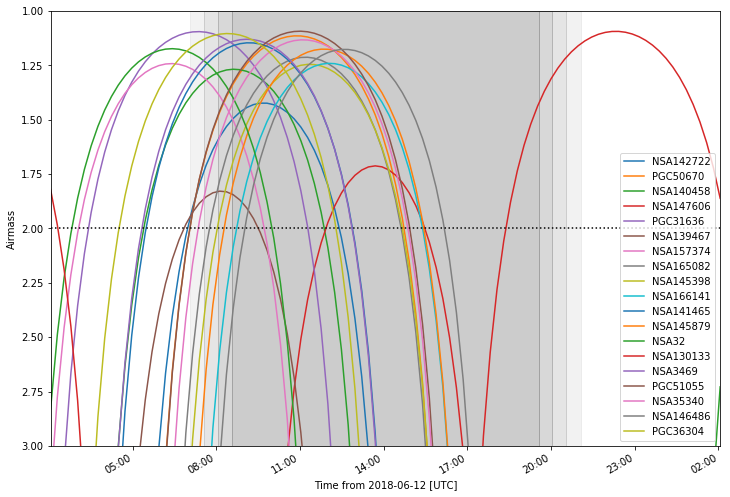

In [215]:
plt.figure(figsize=(12, 8))

astroplan.plots.plot_airmass(list(goodhosts['targetobjs'][goodmsk]), aat, run_mid, 
                             brightness_shading=True)

plt.axhline(2, ls=':', c='k')
plt.legend(loc=0)

### Now the full set

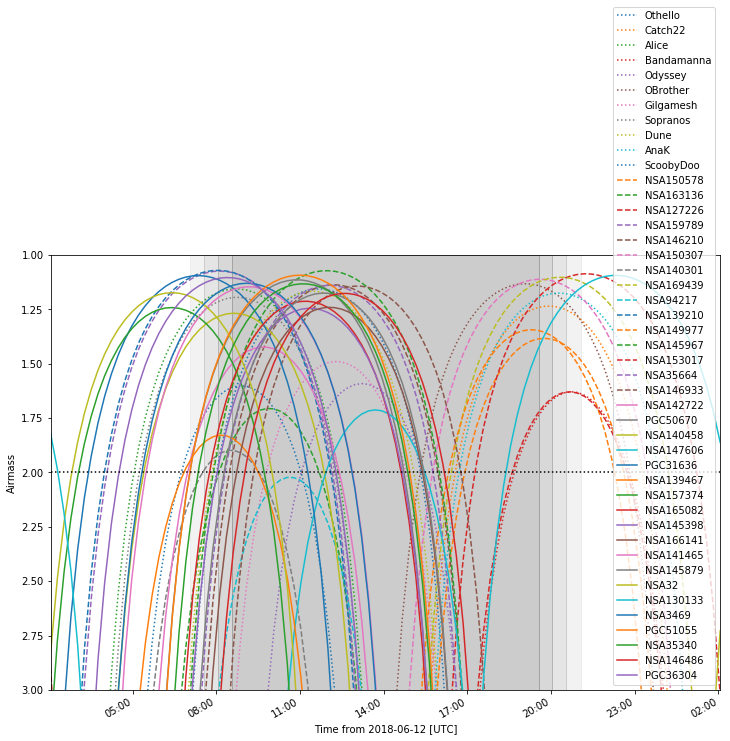

In [214]:
plt.figure(figsize=(12, 8))

astroplan.plots.plot_airmass(list(alreadyobshosts['targetobjs']), aat, run_mid, 
                             style_kwargs=dict(linestyle=':'))
astroplan.plots.plot_airmass(list(nsanotgoodhosts['targetobjs'][nsamsk]), aat, run_mid, 
                             style_kwargs=dict(linestyle='--'))
astroplan.plots.plot_airmass(list(goodhosts['targetobjs'][goodmsk]), aat, run_mid, 
                             brightness_shading=True)

plt.axhline(2, ls=':', c='k')
plt.legend(loc=0)